In [2]:
import os 
import submitit
import numpy as np
import pandas as pd
import mne  

# loading decoding result and add it to summary data 

In [3]:
import os
import pandas as pd
import numpy as np

base_eid_path = '/mnt/data/AdaptiveControl/IBLrawdata/eid_data'
path_summary_data = '/crnldata/cophy/TeamProjects/mohammad/ibl-oscillations/_analyses/_IBLworkflows/preprocessing/clean_data.csv'

summary_data = pd.read_csv(path_summary_data)

# Initialize new columns in the summary_data DataFrame with object dtype to store lists of tuples
summary_data['signif_channel_StimNoStim'] = np.nan
summary_data['signif_channel_RightLeft'] = np.nan
summary_data['signif_channel_BiasLeftBiasRight'] = np.nan

# Ensure the columns are of object type to store lists of tuples
summary_data['signif_channel_StimNoStim'] = summary_data['signif_channel_StimNoStim'].astype(object)
summary_data['signif_channel_RightLeft'] = summary_data['signif_channel_RightLeft'].astype(object)
summary_data['signif_channel_BiasLeftBiasRight'] = summary_data['signif_channel_BiasLeftBiasRight'].astype(object)

for idx, row in summary_data.iterrows():
    eid = row['eid']
    pid = row['pid']
    decoding_path = os.path.join(base_eid_path, eid, 'classification_screener_new.pkl')
    signif_channel_StimNoStim = []
    signif_channel_RightLeft = []
    signif_channel_BiasLeftBiasRight = []
    
    if os.path.isfile(decoding_path):
        decoding_df = pd.read_pickle(decoding_path)
        
        # Check if decoding_df is empty
        if decoding_df.empty:
            print(f'Empty DataFrame for {eid}')
            continue
        
        pid_df = decoding_df[decoding_df['pid'] == pid]
        for channel in pid_df['ch_name'].unique():
            if pid_df.loc[pid_df['ch_name'] == channel, 'nostim_stim_pval'].values[0] < 0.05:
                nostim_stim_acc = pid_df.loc[pid_df['ch_name'] == channel, 'nostim_stim_acc'].values[0]
                signif_channel_StimNoStim.append((channel, nostim_stim_acc))
            if pid_df.loc[pid_df['ch_name'] == channel, 'left_right_pval'].values[0] < 0.05:
                left_right_acc = pid_df.loc[pid_df['ch_name'] == channel, 'left_right_acc'].values[0]
                signif_channel_RightLeft.append((channel, left_right_acc))
            if pid_df.loc[pid_df['ch_name'] == channel, 'biasleft_biasright_pval'].values[0] < 0.05:
                biasleft_biasright_acc = pid_df.loc[pid_df['ch_name'] == channel, 'biasleft_biasright_acc'].values[0]
                signif_channel_BiasLeftBiasRight.append((channel, biasleft_biasright_acc))
        
        # Update the DataFrame with the significant channels and their accuracy values as lists of tuples
        summary_data.at[idx, 'signif_channel_StimNoStim'] = signif_channel_StimNoStim if signif_channel_StimNoStim else np.nan
        summary_data.at[idx, 'signif_channel_RightLeft'] = signif_channel_RightLeft if signif_channel_RightLeft else np.nan
        summary_data.at[idx, 'signif_channel_BiasLeftBiasRight'] = signif_channel_BiasLeftBiasRight if signif_channel_BiasLeftBiasRight else np.nan
    else:
        print(f'No decoding file found for {eid}')
        summary_data.at[idx, 'signif_channel_StimNoStim'] = np.nan
        summary_data.at[idx, 'signif_channel_RightLeft'] = np.nan
        summary_data.at[idx, 'signif_channel_BiasLeftBiasRight'] = np.nan

# # Save the updated summary_data DataFrame to a new CSV file
updated_summary_path = '/crnldata/cophy/TeamProjects/mohammad/ibl-oscillations/_analyses/_IBLworkflows/preprocessing/clean_data_with_significant_channels.csv'
summary_data.to_csv(updated_summary_path, index=False)


No decoding file found for 642c97ea-fe89-4ec9-8629-5e492ea4019d
Empty DataFrame for 9a6e127b-bb07-4be2-92e2-53dd858c2762
No decoding file found for e0928e11-2b86-4387-a203-80c77fab5d52


# The ACC distribution for significant channels

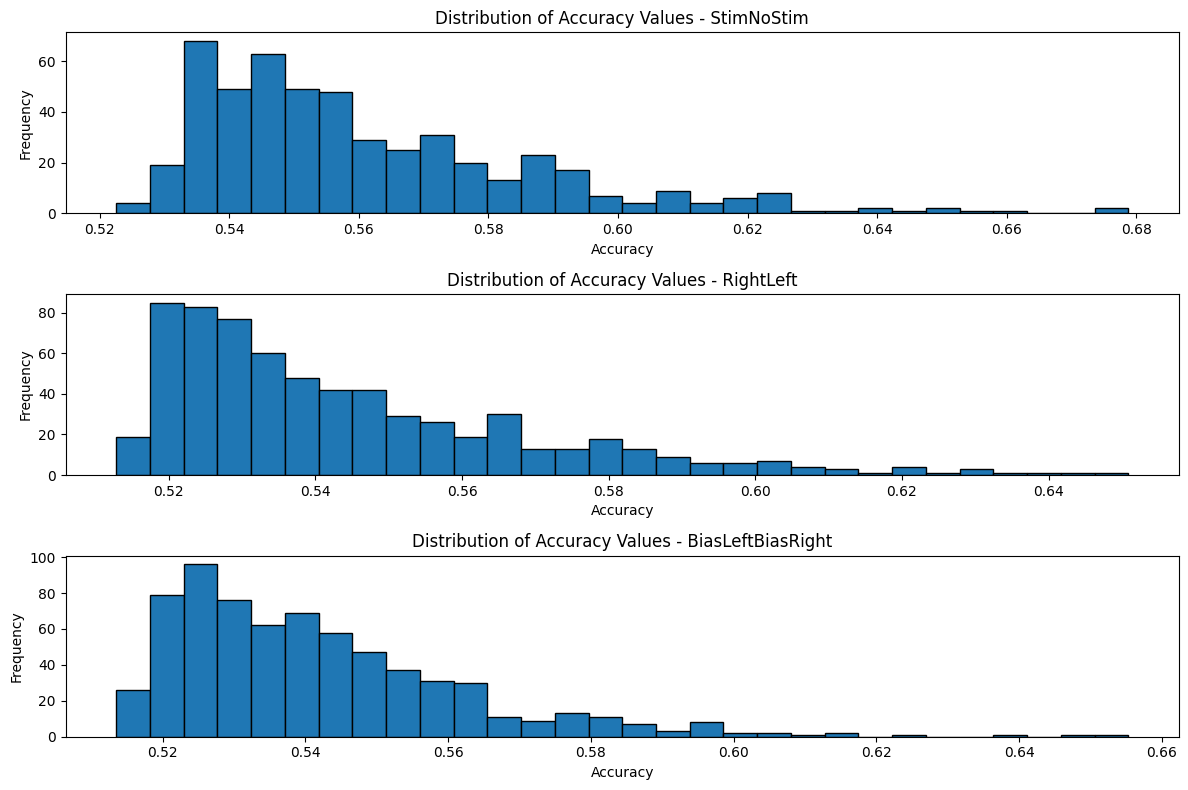

In [4]:
import pandas as pd
import ast
import matplotlib.pyplot as plt

# Load the updated summary_data DataFrame
path_summary_data = '/crnldata/cophy/TeamProjects/mohammad/ibl-oscillations/_analyses/_IBLworkflows/preprocessing/clean_data_with_significant_channels.csv'
summary_data = pd.read_csv(path_summary_data)

# Function to safely evaluate string representation of lists
def safe_eval(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return val

# Apply safe_eval to the relevant columns
summary_data['signif_channel_StimNoStim'] = summary_data['signif_channel_StimNoStim'].apply(safe_eval)
summary_data['signif_channel_RightLeft'] = summary_data['signif_channel_RightLeft'].apply(safe_eval)
summary_data['signif_channel_BiasLeftBiasRight'] = summary_data['signif_channel_BiasLeftBiasRight'].apply(safe_eval)

# Function to extract accuracy values from the significant channels column
def extract_acc_values(signif_channel_col):
    acc_values = []
    for item in signif_channel_col.dropna():
        for channel, acc in item:  # Directly iterate over the list of tuples
            acc_values.append(acc)
    return acc_values

# Extract accuracy values for each condition
acc_values_StimNoStim = extract_acc_values(summary_data['signif_channel_StimNoStim'])
acc_values_RightLeft = extract_acc_values(summary_data['signif_channel_RightLeft'])
acc_values_BiasLeftBiasRight = extract_acc_values(summary_data['signif_channel_BiasLeftBiasRight'])

# Plotting the distributions
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.hist(acc_values_StimNoStim, bins=30, edgecolor='black')
plt.title('Distribution of Accuracy Values - StimNoStim')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')

plt.subplot(3, 1, 2)
plt.hist(acc_values_RightLeft, bins=30, edgecolor='black')
plt.title('Distribution of Accuracy Values - RightLeft')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')

plt.subplot(3, 1, 3)
plt.hist(acc_values_BiasLeftBiasRight, bins=30, edgecolor='black')
plt.title('Distribution of Accuracy Values - BiasLeftBiasRight')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
